<a href="https://colab.research.google.com/github/NicKomarov/comp_lingv_laba1/blob/main/comp_ling_laba1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/author_identification/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/author_identification/test.csv')

train_df['author'].value_counts()

,count
author,
EAP,7900
MWS,6044
HPL,5635


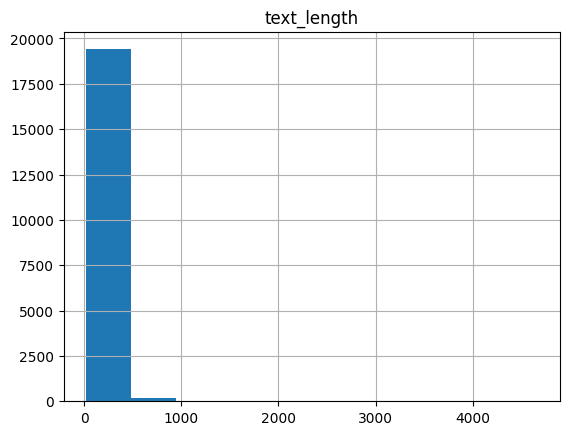

In [ ]:
train_df['text_length'] = train_df['text'].str.len()

train_df.hist()
plt.show()

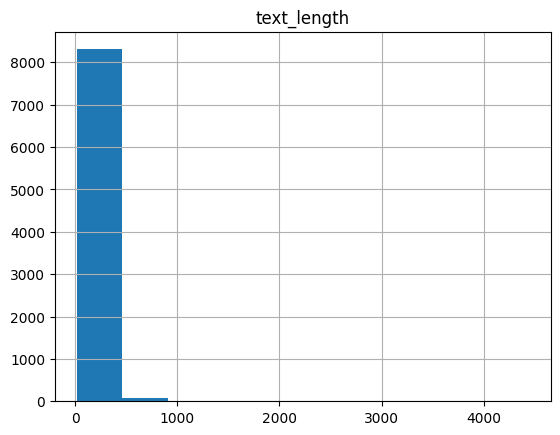

In [ ]:
test_df['text_length'] = test_df['text'].str.len()

test_df.hist()
plt.show()

In [ ]:
train_df['author_num'] = train_df.author.map({'EAP':0, 'HPL':1, 'MWS':2})
train_df.head()

,id,text,author,text_length,author_num
0,id26305,"This process, however, afforded me no means of...",EAP,231,0
1,id17569,It never once occurred to me that the fumbling...,HPL,71,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174,1


In [ ]:
from sklearn.model_selection import train_test_split

X = train_df['text']
y = train_df['author_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, '\n')
print(y_train.value_counts(),'\n', y_test.value_counts())

(15663,) (15663,) (3916,) (3916,) 

author_num
0    6330
2    4800
1    4533
Name: count, dtype: int64 
 author_num
0    1570
2    1244
1    1102
Name: count, dtype: int64


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#vect = TfidfVectorizer(ngram_range=(1, 1), max_features = 1000)
vect = CountVectorizer(ngram_range=(1, 1), lowercase=False, token_pattern=r'(?u)\b\w+\b|\,|\.|\;|\:')

vect

CountVectorizer(lowercase=False, token_pattern='(?u)\\b\\w+\\b|\\,|\\.|\\;|\\:')

In [ ]:
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [ ]:
from scipy.sparse import csr_matrix, hstack
from string import punctuation


def avg_chars_per_sentence(text):
    sentences = text.split('.')
    sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
    return np.mean([len(s) for s in sentences]) if sentences else 0


def avg_punct_per_sentence(text):
    sentences = text.split('.')
    sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
    return np.mean([sum(1 for c in s if c in punctuation) for s in sentences]) if sentences else 0


X_train_avg_chars = X_train.apply(avg_chars_per_sentence)
X_train_avg_punct = X_train.apply(avg_punct_per_sentence)

X_test_avg_chars = X_test.apply(avg_chars_per_sentence)
X_test_avg_punct = X_test.apply(avg_punct_per_sentence)


def add_feature(X, feature_to_add):
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

X_train_dtm = add_feature(X_train_dtm, [X_train_avg_chars, X_train_avg_punct])
X_test_dtm = add_feature(X_test_dtm, [X_test_avg_chars, X_test_avg_punct])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb

MultinomialNB()

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_values = {'alpha':[0.01, 0.1, 1.0, 10.0, 100.0]}
grid_nb = GridSearchCV(nb, param_grid=grid_values, scoring='neg_log_loss')
grid_nb.fit(X_train_dtm, y_train)
grid_nb.best_params_

{'alpha': 1.0}

In [ ]:
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [ ]:
from sklearn import metrics

y_pred_test = nb.predict(X_test_dtm)
metrics.accuracy_score(y_test, y_pred_test)

0.8457609805924413

In [ ]:
y_pred_train = nb.predict(X_train_dtm)
metrics.accuracy_score(y_train, y_pred_train)

0.9201302432484199

In [ ]:
metrics.confusion_matrix(y_test, y_pred_test)

array([[1315,   95,  160],
       [ 112,  895,   95],
       [ 100,   42, 1102]])

In [ ]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix


train_accuracy = accuracy_score(y_train, nb.predict(X_train_dtm))
train_loss = log_loss(y_train, nb.predict_proba(X_train_dtm))
test_accuracy = accuracy_score(y_test, y_pred_test)

conf_matrix = confusion_matrix(y_test, y_pred_test)


print("Training Accuracy:", train_accuracy)
print("Training Loss:", train_loss)
print("\nConfusion Matrix:\n", conf_matrix)


Training Accuracy: 0.9201302432484199
Training Loss: 0.21693907777976312

Confusion Matrix:
 [[1315   95  160]
 [ 112  895   95]
 [ 100   42 1102]]



Classification Report:

              precision    recall  f1-score   support

         EAP       0.86      0.84      0.85      1570
         HPL       0.87      0.81      0.84      1102
         MWS       0.81      0.89      0.85      1244

    accuracy                           0.85      3916
   macro avg       0.85      0.85      0.85      3916
weighted avg       0.85      0.85      0.85      3916



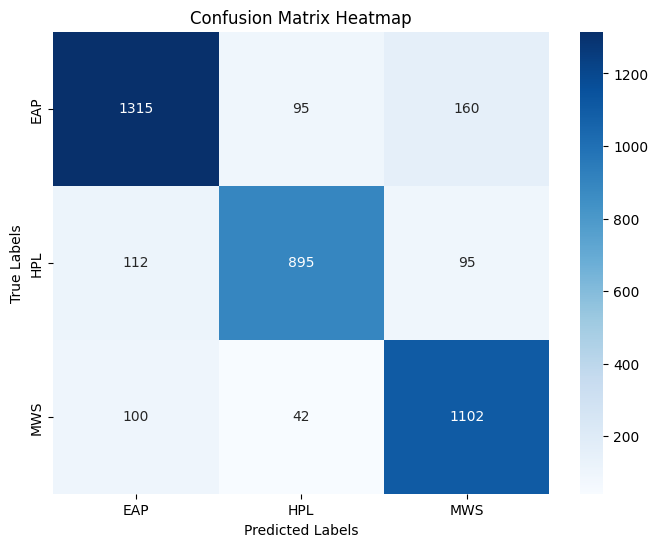

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt


class_report = classification_report(y_test, y_pred_test, target_names=['EAP', 'HPL', 'MWS'])
print("\nClassification Report:\n")
print(class_report)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['EAP', 'HPL', 'MWS'], yticklabels=['EAP', 'HPL', 'MWS'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
